In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import os
import pint
import json
import pprint

from scipy import stats
from scipy.optimize import curve_fit


from pygama.flow import DataLoader
from pygama.flow import FileDB
from pygama.lgdo.lh5_store import LH5Store
from pygama.lgdo import ls, Table, WaveformTable
from pygama.dsp import build_dsp

# Setup FileDB and DataLoader

In [ ]:
# Run this to perform a scan of all files and create a FileDB from scratch, then save it to disk
fdb = FileDB(config="metadata/dataloader_configs/cage_filedb_config.json")
fdb.to_disk("cage_filedb.lh5", "o")

In [2]:
# Run this to load an existing FileDB from disk
fdb = FileDB("cage_filedb.lh5")

In [63]:
dl = DataLoader(config="metadata/dataloader_configs/cage_loader_config.json",
                filedb=fdb)

In [64]:
cyc = 2755 # Set this to the cycle you want to do optimization on
dl.set_files(f"cycle == {cyc}")
dl.set_output(fmt="pd.DataFrame", columns=["energy"])
el = dl.build_entry_list(save_output_columns=True)
data = dl.load(el)

Building entry list: 100%|██████████| 1/1 [00:00<00:00, 2822.55 keys/s, key=2755]

Below you can check the spectrum to make sure it looks okay, then you can zoom in and pick out where the 1460 kev peak is. 

In [5]:
#%matplotlib widget

Text(0, 0.5, 'count')

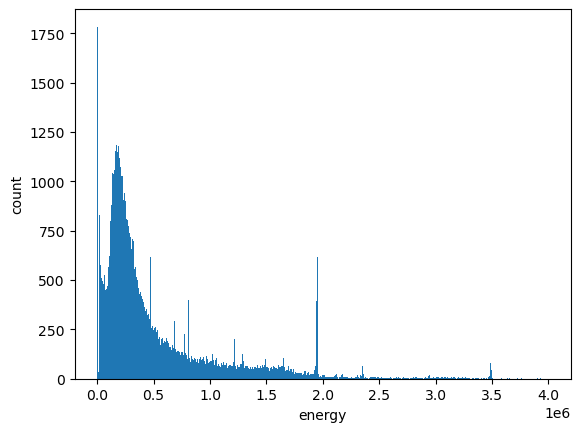

In [65]:
%matplotlib inline
plt.figure()
#plt.yscale('log')
plt.hist(data['energy'], bins = np.linspace(0, 4e6, 1000))
plt.xlabel('energy')
plt.ylabel('count')

Text(0, 0.5, 'count')

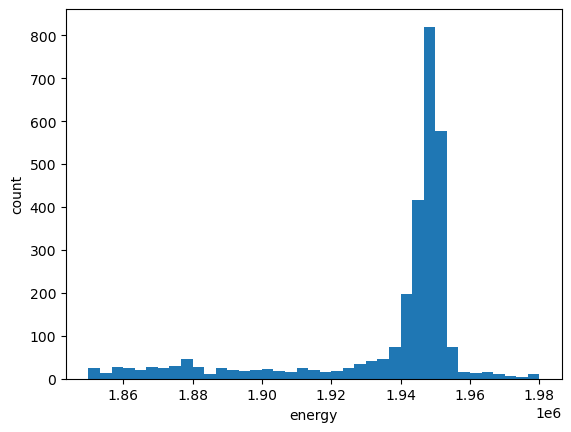

In [66]:
plt.figure()
plt.hist(data['energy'], bins = np.linspace(1.85e6, 1.98e6, 40))
plt.xlabel('energy')
plt.ylabel('count')

In [67]:
# input the low and high ends of the 1460 kev peak here
elo = 1.93e6
ehi = 1.96e6

# Load 1460 keV Waveforms

In [68]:
dl.reset()
dl.set_files(f"cycle == {cyc}")
dl.set_cuts({"hit": f"energy > {elo} and energy < {ehi}"})
dl.set_output(columns=["waveform"])
wfs = dl.load()

Building entry list: 100%|██████████| 1/1 [00:00<00:00, 3228.87 keys/s, key=2755]

Here we have to manually add units to waveform columns because I haven't implemented that in DataLoader yet, then run a quick check that the units are right.

In [69]:
wfs['waveform']['dt'].attrs['units'] = 'ns'
wfs['waveform']['t0'].attrs['units'] = 'ns'

In [70]:
raw = fdb.df.query(f"cycle == {cyc}").iloc[0]
raw = os.path.join(fdb.data_dir, fdb.tier_dirs['raw'], raw['raw_file'])

In [71]:
sto = LH5Store()
check, _ = sto.read_object("ORSIS3302DecoderForEnergy/raw/waveform", raw)
assert check['dt'].attrs == wfs['waveform']['dt'].attrs
assert check['t0'].attrs == wfs['waveform']['t0'].attrs

In [72]:
# Save waveforms to a temporary "raw" file
raw_file = "1460raw_temp.lh5"
# sto.write_object(obj=wfs["energy"], name="energy", lh5_file=raw_file, group="raw")
sto.write_object(obj=wfs, name="40K", lh5_file=raw_file, wo_mode="of")

In [73]:
ureg = pint.UnitRegistry()
per_unit = 1/(wfs['waveform']['dt'].nda[0] * ureg(wfs['waveform']['dt'].attrs['units']).units)
per_us = per_unit.to("1/us")
print(per_unit)
print(per_us)

0.1 / nanosecond
100.0 / microsecond


# First Pass DSP
We run the DSP once to find a reasonable guess for `pz_tau` and bins for our energy histogram

In [74]:
dsp_db = {
    "40K": {
        "etrap": {
            "rise": "8*us",
            "flat": "2*us"
        },
        "pz": {
            "tau": "70*us"
        },
        "dcr_trap": {
            "rise": "8*us",
            "flat": "2*us"
        },
        "ctc": {
            "alpha": 1
        }
    }
}
dsp_config = {
  "outputs": [
    "trapEmax", "lt_slope"
  ],
  "processors":{
    "bl, bl_sig, bl_slope, bl_intercept":{
      "function": "linear_slope_fit",
      "module": "pygama.dsp.processors",
      "args" : ["waveform[0: 3500]", "bl","bl_sig", "bl_slope","bl_intercept"],
      "unit": ["ADC","ADC","ADC","ADC"]
    },
    "wf_blsub":{
      "function": "subtract",
      "module": "numpy",
      "args": ["waveform", "bl", "wf_blsub"],
      "prereqs": ["waveform", "bl"],
      "unit": "ADC"
    },
    "wf_logtail": {
      "function": "log",
      "module": "numpy",
      "args": ["wf_blsub[4250:8000]", "wf_logtail"],
      "unit": "ADC",
      "prereqs": ["wf_blsub"]
    },
    "lt_mean, lt_sig, lt_slope, lt_int": {
        "function": "linear_slope_fit",
        "module": "pygama.dsp.processors",
        "args": ["wf_logtail", "lt_mean", "lt_sig", "lt_slope", "lt_int"],
        "unit": ["ADC", "ADC", "ADC", "ADC"],
        "prereqs": ["wf_logtail"]
    },
    "wf_pz": {
      "function": "pole_zero",
      "module": "pygama.dsp.processors",
      "args": ["wf_blsub", "db.pz.tau", "wf_pz"],
      "prereqs": ["wf_blsub"],
      "unit": "ADC",
    },
    "wf_etrap": {
      "function": "trap_norm",
      "module": "pygama.dsp.processors",
      "prereqs": ["wf_pz"],
      "args": ["wf_pz", "db.etrap.rise", "db.etrap.flat", "wf_etrap"],
      "unit": "ADC"
    },
    "trapEmax": {
      "function": "amax",
      "module": "numpy",
      "args": ["wf_etrap", 1, "trapEmax"],
      "kwargs": {"signature":"(n),()->()", "types":["fi->f"]},
      "unit": "ADC",
      "prereqs": ["wf_etrap"]
    },
    "trapEmax_ctc": {
      "function": "add",
      "module": "numpy",
      "args": ["trapEmax", "db.ctc.alpha*dcr", "trapEmax_ctc"],
      "unit": "ADC",
      "prereqs": ["trapEmax", "dcr"]
    },
    "tp_min, tp_max, wf_min, wf_max":{
      "function": "min_max",
      "module": "pygama.dsp.processors",
      "args": ["wf_blsub", "tp_min", "tp_max", "wf_min", "wf_max"],
      "unit": ["ns","ns","ADC", "ADC"],
      "prereqs": ["wf_blsub"]
    },
    "pz_mean, pz_sig, pz_slope, pz_int": {
        "function": "linear_slope_fit",
        "module": "pygama.dsp.processors",
        "args": ["wf_pz[5750:8000]", "pz_mean", "pz_sig", "pz_slope", "pz_int"],
        "unit": ["ADC", "ADC", "ADC", "ADC"],
        "prereqs": ["wf_pz"]
    },
    "wf_dcr_trap": {
        "function": "trap_norm",
        "module": "pygama.dsp.processors",
        "args": ["wf_pz", "db.dcr_trap.rise", "db.dcr_trap.flat", "wf_dcr_trap"],
        "defaults" : {"db.dcr_trap.rise":"7*us", "db.dcr_trap.flat":"20*us"},
        "unit": "ADC",
        "prereqs": ["wf_pz"]
    },
    "dcr": {
        "function": "fixed_time_pickoff",
        "module": "pygama.dsp.processors",
        "args": ["wf_dcr_trap", "db.dcr.ftp", "i", "dcr"],
        "defaults" : {"db.dcr.ftp" : "80*us"},
        "unit": "ADC",
        "prereqs": ["wf_dcr_trap"]
    }
  }
}


In [75]:
dsp_file = "1460dsp_temp.lh5"
build_dsp(f_raw=raw_file, f_dsp=dsp_file, dsp_config=dsp_config, database=dsp_db, write_mode='r')

/global/u2/g/grsong/legend/pygama/src/pygama/dsp/processing_chain.py:1228: RuntimeWarning: invalid value encountered in log
  self.processor(*self.args, **self.kwargs)
/global/u2/g/grsong/legend/pygama/src/pygama/dsp/processing_chain.py:1228: RuntimeWarning: divide by zero encountered in log
  self.processor(*self.args, **self.kwargs)
/opt/anaconda3/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:170: RuntimeWarning: invalid value encountered in linear_slope_fit
  return self.ufunc(*args, **kwargs)
Processing table 40K: 100%|██████████| 2263/2263 [00:03<00:00, 677.48 rows/s]


In [76]:
pk_table, _ = sto.read_object("40K", dsp_file)
pk_df = pk_table.get_dataframe()

In [77]:
lt_tau = 1 / (pk_df['lt_slope'].mean()*per_us.magnitude) # ADC/sample * samples/us = ADC/us
tau_range = -np.arange(lt_tau - 1, lt_tau + 1, .2)

In [78]:
emed = pk_df.median()['trapEmax']
ebins = np.linspace(emed - 0.02*emed, emed + 0.02*emed, 20)

In [79]:
rise_range = np.arange(5, 15)
dcrrise_range = np.arange(2, 5)
dcrflat_range = np.arange(18, 21)
alpha_range = np.linspace(0.5, 15, 10)

(array([0., 0., 0., ..., 0., 0., 0.]),
 array([3377.23719238, 3384.49226691, 3391.74734144, ..., 3500.57345934,
        3507.82853387, 3515.0836084 ]),
 [<matplotlib.patches.Polygon at 0x7fff9aac1e50>])

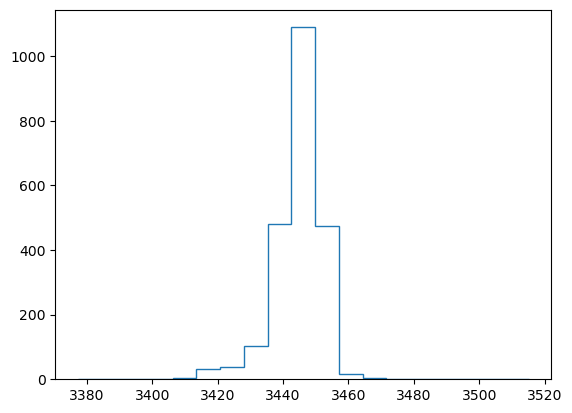

In [82]:
#plt.hist(pk_df['trapEmax_ctc'], bins=ebins, histtype='step')
plt.hist(pk_df['trapEmax'], bins=ebins, histtype='step')

In [83]:
print(lt_tau)
print(tau_range)
print(rise_range)
print(dcrrise_range)
print(dcrflat_range)
print(ebins)
print(alpha_range)

-64.46853532074816
[65.46853532 65.26853532 65.06853532 64.86853532 64.66853532 64.46853532
 64.26853532 64.06853532 63.86853532 63.66853532]
[ 5  6  7  8  9 10 11 12 13 14]
[2 3 4]
[18 19 20]
[3377.23719238 3384.49226691 3391.74734144 ... 3500.57345934 3507.82853387
 3515.0836084 ]
[ 0.5         2.11111111  3.72222222  5.33333333  6.94444444  8.55555556
 10.16666667 11.77777778 13.38888889 15.        ]


# DSP Loop

In [84]:
dsp_config["outputs"] = ["pz_slope", "trapEmax", "dcr", "trapEmax_ctc"]
dsp_config["processors"].pop("wf_logtail")
dsp_config["processors"].pop("lt_mean, lt_sig, lt_slope, lt_int")

{'function': 'linear_slope_fit',
 'module': 'pygama.dsp.processors',
 'args': ['wf_logtail', 'lt_mean', 'lt_sig', 'lt_slope', 'lt_int'],
 'unit': ['ADC', 'ADC', 'ADC', 'ADC'],
 'prereqs': ['wf_logtail']}

## Pole Zero Loop

Here we are finding the optimum time constant for the decay of the tail, determined by which one gives the flattest slope of the tail once pole-zero corrected

In [95]:
results = None
for tau in tau_range:
    dsp_db["40K"]["pz"]["tau"] = str(tau) + " * us"
        
    dsp_file = "1460dsp_temp.lh5"
    build_dsp(f_raw=raw_file, f_dsp=dsp_file, dsp_config=dsp_config, database=dsp_db, write_mode='r', n_max=20)
    
    pk_table, _ = sto.read_object("40K", dsp_file)
    res = pd.DataFrame({
        "tau": [tau],
        "pz_slope_avg": [np.nanmean(np.abs(pk_table['pz_slope'].nda))]
    })
    if results is None:
        results = res
    else:
        results = pd.concat([results, res], ignore_index=True)
print(results)

         tau  pz_slope_avg
0  64.500000      0.005963
1  64.722222      0.004788
2  64.944444      0.003619
3  65.166667      0.002459
4  65.388889      0.001346
5  65.611111      0.000737
6  65.833333      0.001216
7  66.055556      0.002219
8  66.277778      0.003228
9  66.500000      0.004333


If the best result is at the edge of the range, reset `tau_range` to explore more values, and run the above loop again

In [94]:
tau_range = np.linspace(64.5, 66.5, 10)

Set the DB value to the best tau we found and then plot `wf_pz` to look at the tails

In [96]:
tau = results.abs().sort_values("pz_slope_avg").iloc[0]['tau']
print(tau)
dsp_db["40K"]["pz"]["tau"] = str(tau) + "* us"

65.61111111111111


Processing table 40K: 100%|██████████| 2263/2263 [00:03<00:00, 751.27 rows/s]


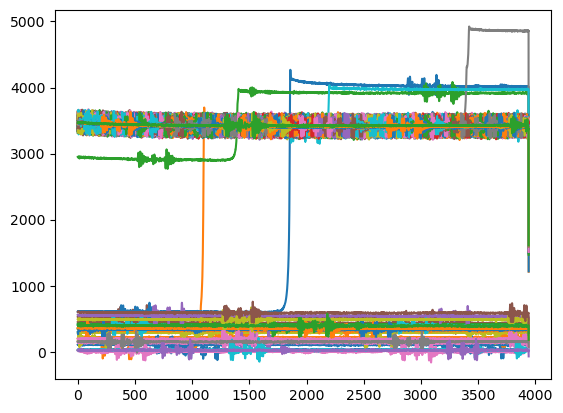

In [97]:
dsp_config["outputs"].append("wf_pz")
build_dsp(f_raw=raw_file, f_dsp=dsp_file, dsp_config=dsp_config, database=dsp_db, write_mode='r')
pk_table, _ = sto.read_object("40K", dsp_file)
plt.figure()
for wf in pk_table['wf_pz']['values'].nda:
    plt.plot(wf[4250:])
dsp_config["outputs"] = dsp_config["outputs"][:-1]

## Energy Trap Loop

We vary the `rise` parameter in the energy trapezoid to find which one gives the highest peak for the 1460 keV line. 

In [101]:
results = None
for rise in rise_range:
    dsp_db["40K"]["etrap"]["rise"] = str(rise) + " * us"
        
    dsp_file = "1460dsp_temp.lh5"
    build_dsp(f_raw=raw_file, f_dsp=dsp_file, dsp_config=dsp_config, database=dsp_db, write_mode='r')
    
    pk_table, _ = sto.read_object("40K", dsp_file)
    
    # These lines will plot each energy histogram
    #plt.figure()
    #plt.yscale('log')
    #ehist, _, _ = plt.hist(pk_table['trapEmax'].nda, bins = np.linspace(3300, 3600, 50), label=rise)
    #plt.legend()
    
    # This one just runs and tells the answer
    ehist, _ = np.histogram(pk_table['trapEmax'].nda, bins = ebins)
    
    res = pd.DataFrame({
        "rise": [rise],
        "peak_height": [np.max(ehist)]
    })
    if results is None:
        results = res
    else:
        results = pd.concat([results, res], ignore_index=True)
print(results)

Processing table 40K: 100%|██████████| 2263/2263 [00:02<00:00, 771.91 rows/s]

    rise  peak_height
0      1          539
1      2          716
2      3          903
3      4          969
4      5         1077
5      6         1074
6      7          940
7      8         1184
8      9          949
9     10         1207
10    11         1183
11    12          997
12    13         1249
13    14         1292
14    15         1088
15    16         1064
16    17         1255


In [100]:
rise_range = np.arange(1, 18)

Text(0, 0.5, 'peak height')

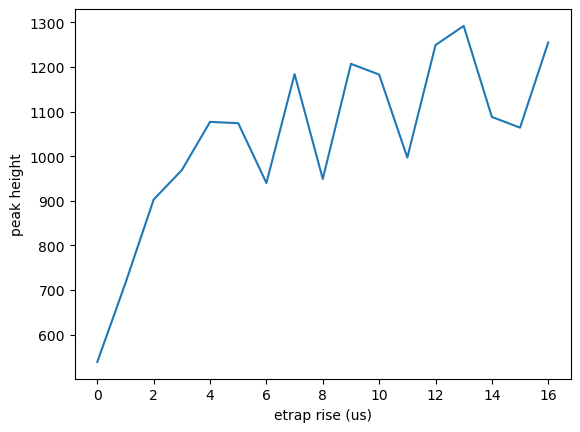

In [103]:
plt.figure()
plt.plot(results["peak_height"])
plt.xlabel("etrap rise (us)")
plt.ylabel("peak height")

In [104]:
rise = results.abs().sort_values("peak_height").iloc[-1]['rise']
print(rise)
dsp_db["40K"]["etrap"]["rise"] = str(rise) + "* us"

14


## DCR Loop

We do a grid-search on both the `rise` and `flat` parameters for the DCR trapezoid that give us a DCR centered around zero.

In [109]:
results = None
for rise in dcrrise_range:
    for flat in dcrflat_range:
        dsp_db["40K"]["dcr_trap"]["rise"] = str(rise) + " * us"
        dsp_db["40K"]["dcr_trap"]["flat"] = str(flat) + " * us"

        dsp_file = "1460dsp_temp.lh5"
        build_dsp(f_raw=raw_file, f_dsp=dsp_file, dsp_config=dsp_config, database=dsp_db, write_mode='r')

        pk_table, _ = sto.read_object("40K", dsp_file)

        res = pd.DataFrame({
            "rise": [rise],
            "flat": [flat],
            "dcr_mean": [np.abs(np.mean(pk_table['dcr'].nda))]
        })
        if results is None:
            results = res
        else:
            results = pd.concat([results, res], ignore_index=True)
print(results)

Processing table 40K: 100%|██████████| 2263/2263 [00:04<00:00, 562.35 rows/s]

    rise   flat  dcr_mean
0   2.50  19.75  1.085440
1   2.50  20.00  0.889022
2   2.50  20.25  0.681264
3   2.50  20.50  0.432856
4   2.75  19.75  0.707463
5   2.75  20.00  0.476087
6   2.75  20.25  0.194773
7   2.75  20.50  0.096388
8   3.00  19.75  0.239080
9   3.00  20.00  0.049048
10  3.00  20.25  0.367347
11  3.00  20.50  0.704362
12  3.25  19.75  0.307767
13  3.25  20.00  0.631739
14  3.25  20.25  0.908994
15  3.25  20.50  1.170478


If the best result is at the edge of the range, reset `dcrrise_range` and `dcrflat_range` to explore more values, and run the above loop again

In [108]:
dcrrise_range = np.linspace(2.5, 3.25, 4)
dcrflat_range = np.linspace(19.75, 20.5, 4)

Set the DB value to the best tau we found and then plot `wf_pz` to look at the tails

In [110]:
dcrrise = results.abs().sort_values("dcr_mean").iloc[0]['rise']
dcrflat = results.abs().sort_values("dcr_mean").iloc[0]['flat']
print(dcrrise, dcrflat)
dsp_db["40K"]["dcr_trap"]["rise"] = str(dcrrise) + "* us"
dsp_db["40K"]["dcr_trap"]["flat"] = str(dcrflat) + "* us"

3.0 20.0


## Charge Trapping Correction

We want to correct our energy estimation by adding a value to `trapEftp` based on the DCR. 
- trapEftp_ctc = trapEftp + alpha*DCR

We are trying to optimize a value for `alpha` that gives the highest peak for the 1460 keV line

In [113]:
results = None
for alpha in alpha_range:
    dsp_db["40K"]["ctc"]["alpha"] = str(alpha)
        
    dsp_file = "1460dsp_temp.lh5"
    build_dsp(f_raw=raw_file, f_dsp=dsp_file, dsp_config=dsp_config, database=dsp_db, write_mode='r')
    
    pk_table, _ = sto.read_object("40K", dsp_file)
    
    # These lines will plot each energy histogram
    #plt.figure()
    #plt.yscale('log')
    #ehist, _, _ = plt.hist(pk_table['trapEmax_ctc'].nda, bins = ebins, label=alpha)
    #plt.legend()
    
    # This one just runs and tells the answer
    ehist, _ = np.histogram(pk_table['trapEmax_ctc'].nda, bins = ebins)
    
    res = pd.DataFrame({
        "alpha": [alpha],
        "peak_height": [np.max(ehist)]
    })
    if results is None:
        results = res
    else:
        results = pd.concat([results, res], ignore_index=True)
print(results)

Processing table 40K: 100%|██████████| 2263/2263 [00:03<00:00, 654.90 rows/s]

    alpha  peak_height
0     0.0         1292
1     0.1         1250
2     0.2         1210
3     0.3         1155
4     0.4         1087
5     0.5         1033
6     0.6          962
7     0.7          897
8     0.8          915
9     0.9          949
10    1.0          973


If the best result is at the edge of the range, reset `alpha_range` to explore more values, and run the above loop again

In [112]:
alpha_range = np.append([0], np.linspace(0.1, 1, 10))

In [114]:
alpha = results.abs().sort_values("peak_height").iloc[-1]['alpha']
print(alpha)
dsp_db["40K"]["ctc"]["alpha"] = alpha

0.0


Processing table 40K: 100%|██████████| 2263/2263 [00:03<00:00, 638.48 rows/s]


(array([0., 0., 0., ..., 0., 0., 0.]),
 array([3377.23719238, 3384.49226691, 3391.74734144, ..., 3500.57345934,
        3507.82853387, 3515.0836084 ]),
 [<matplotlib.patches.Polygon at 0x7fff989601f0>])

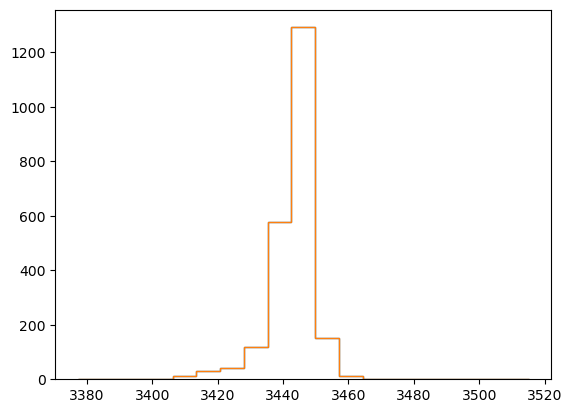

In [115]:
build_dsp(f_raw=raw_file, f_dsp=dsp_file, dsp_config=dsp_config, database=dsp_db, write_mode='r')
pk_table, _ = sto.read_object("40K", dsp_file)
plt.figure()
plt.hist(pk_table['trapEmax'].nda, bins=ebins, histtype='step')
plt.hist(pk_table['trapEmax_ctc'].nda, bins=ebins, histtype='step')

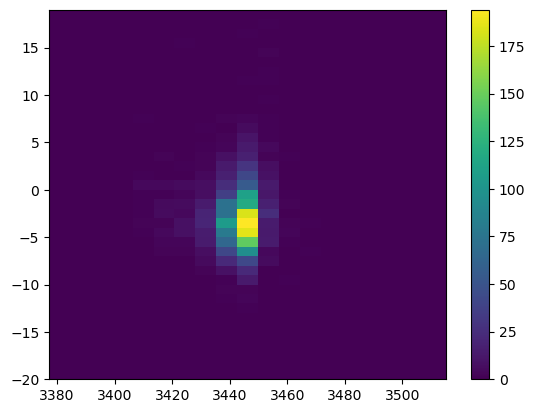

In [116]:
plt.figure()
plt.hist2d(pk_table['trapEmax'].nda, pk_table['dcr'].nda, bins=(ebins, np.arange(-20, 20)))
plt.colorbar()

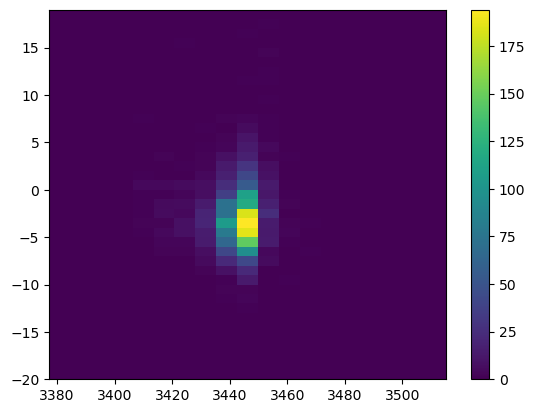

In [117]:
plt.figure()
plt.hist2d(pk_table['trapEmax_ctc'].nda, pk_table['dcr'].nda, bins=(ebins, np.arange(-20, 20)))
plt.colorbar()

# Run On One File

In [119]:
raw = fdb.df.query(f"cycle == {cyc}").iloc[0]
raw = os.path.join(fdb.data_dir, fdb.tier_dirs['raw'], raw['raw_file'])
dsp = f"cycle{cyc}_testdsp.lh5"

In [120]:
# Write results to dsp_07.json defaults
with open('./metadata/dsp/dsp_07.json') as f:
    test_config = json.load(f)
test_config['processors']['wf_pz']['defaults'] = {"db.pz.tau": dsp_db['40K']['pz']['tau']}
test_config['processors']['wf_etrap']['defaults'] = {"db.etrap.rise": dsp_db['40K']['etrap']['rise'], 
                                                  "db.etrap.flat": dsp_db['40K']['etrap']['flat']}
test_config['processors']['wf_dcr_trap']['defaults'] = {"db.dcr_trap.rise": dsp_db['40K']['dcr_trap']['rise'], 
                                                  "db.dcr_trap.flat": dsp_db['40K']['dcr_trap']['flat']}
test_config['processors']['trapEmax_ctc']['defaults'] = {"db.ctc.alpha": dsp_db['40K']['ctc']['alpha']}

In [ ]:
pprint.pprint(dsp_db)

In [ ]:
pprint.pprint(test_config)

In [121]:
build_dsp(f_raw=raw, f_dsp=dsp, dsp_config=test_config, write_mode='r')

/global/u2/g/grsong/legend/pygama/src/pygama/dsp/processing_chain.py:1228: RuntimeWarning: invalid value encountered in log
  self.processor(*self.args, **self.kwargs)
Processing table ORSIS3302DecoderForEnergy/raw:   5%|▌         | 6400/122103 [00:21<06:38, 290.43 rows/s]/global/u2/g/grsong/legend/pygama/src/pygama/dsp/processing_chain.py:1228: RuntimeWarning: divide by zero encountered in log
  self.processor(*self.args, **self.kwargs)
Processing table ORSIS3302DecoderForEnergy/raw: 100%|██████████| 122103/122103 [06:54<00:00, 294.49 rows/s]


In [ ]:
ls(dsp, 'ORSIS3302DecoderForEnergy/dsp/*')

In [122]:
dsp_table, _ = sto.read_object("ORSIS3302DecoderForEnergy/dsp", dsp)

(array([5., 4., 3., ..., 1., 1., 1.]),
 array([3200.        , 3200.80160321, 3201.60320641, ..., 3598.39679359,
        3599.19839679, 3600.        ]),
 <BarContainer object of 499 artists>)

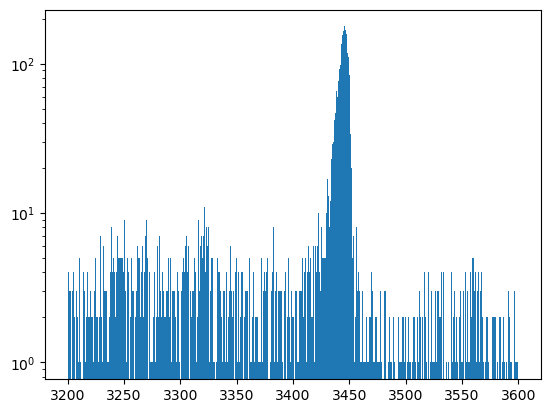

In [125]:
# energy histogram
plt.figure()
plt.yscale('log')
plt.hist(dsp_table['trapEmax'].nda, bins=np.linspace(3200, 3600, 500))

(array([5., 6., 8., ..., 0., 0., 0.]),
 array([2600.        , 2602.63157895, 2605.26315789, ..., 2644.73684211,
        2647.36842105, 2650.        ]),
 <BarContainer object of 19 artists>)

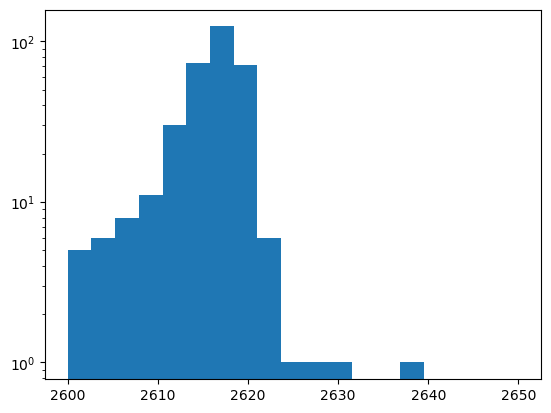

In [126]:
# check linearity
k40_peak = 3440
plt.figure()
plt.yscale('log')
plt.hist(dsp_table['trapEmax'].nda*(1460/k40_peak), bins=np.linspace(2600, 2650, 20))

(array([1., 0., 0., ..., 3., 6., 4.]),
 array([-50, -49, -48, ...,  47,  48,  49]),
 <BarContainer object of 99 artists>)

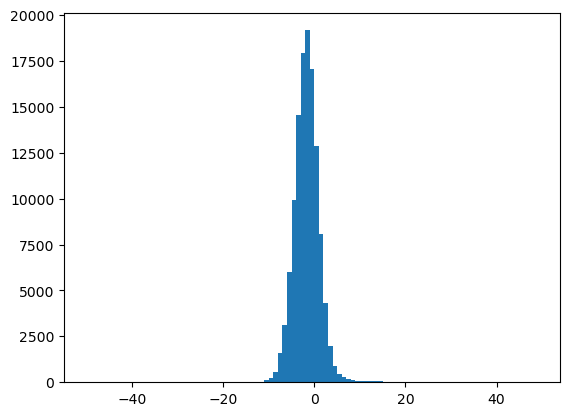

In [127]:
# dcr histogram
plt.figure()
plt.hist(dsp_table['dcr'].nda, bins=np.arange(-50, 50))

(-50.0, 50.0)

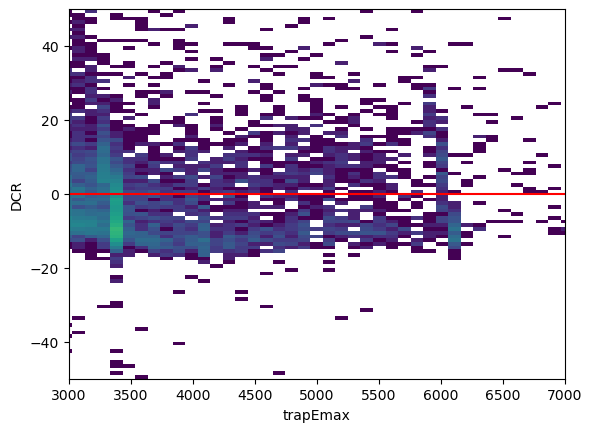

In [55]:
plt.figure()
plt.hist2d(dsp_table['trapEmax'].nda, dsp_table['dcr'].nda, 
           bins = (np.linspace(0, 10000, 100), np.arange(-200, 200)), 
           norm=colors.LogNorm())
plt.xlabel("trapEmax")
plt.ylabel("DCR")
plt.axhline(0, color='r')
plt.xlim(3000, 7000)
plt.ylim(-50, 50)

(-50.0, 50.0)

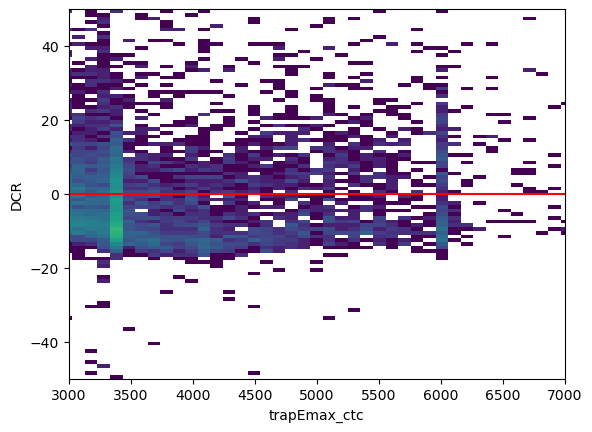

In [56]:
plt.figure()
plt.hist2d(dsp_table['trapEmax_ctc'].nda, dsp_table['dcr'].nda, 
           bins = (np.linspace(0, 10000, 100), np.arange(-200, 200)), 
           norm=colors.LogNorm())
plt.xlabel("trapEmax_ctc")
plt.ylabel("DCR")
plt.axhline(0, color='r')
plt.xlim(3000, 7000)
plt.ylim(-50, 50)

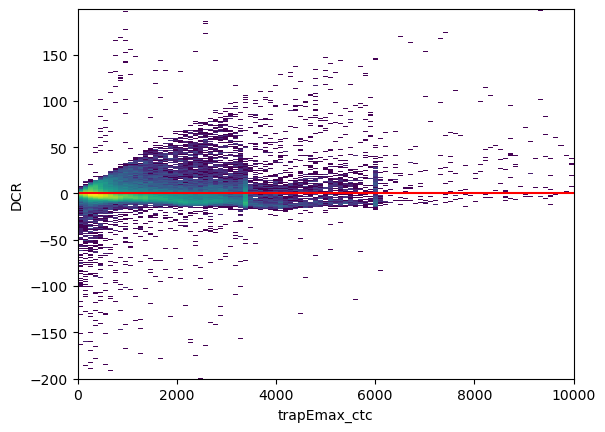

In [59]:
plt.figure()
plt.hist2d(dsp_table['trapEmax_ctc'].nda, dsp_table['dcr'].nda, 
           bins = (np.linspace(0, 10000, 100), np.arange(-200, 200)), 
           norm=colors.LogNorm())
plt.xlabel("trapEmax_ctc")
plt.ylabel("DCR")
plt.axhline(0, color='r')

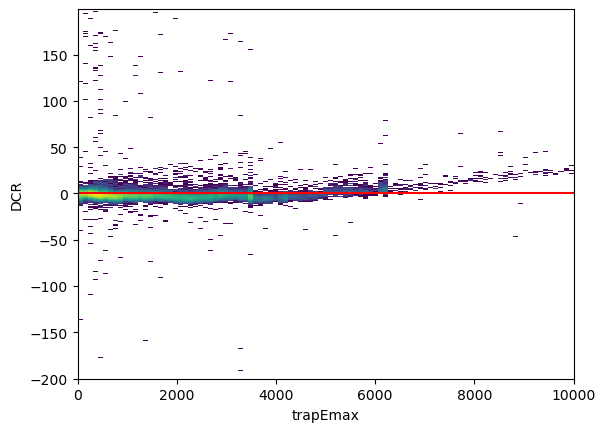

In [128]:
plt.figure()
plt.hist2d(dsp_table['trapEmax'].nda, dsp_table['dcr'].nda, 
           bins = (np.linspace(0, 10000, 100), np.arange(-200, 200)), 
           norm=colors.LogNorm())
plt.xlabel("trapEmax")
plt.ylabel("DCR")
plt.axhline(0, color='r')

(array([54., 43., 40., ..., 24., 19., 17.]),
 array([3000.        , 3010.20408163, 3020.40816327, ..., 3479.59183673,
        3489.79591837, 3500.        ]),
 [<matplotlib.patches.Polygon at 0x7fff9b17a070>])

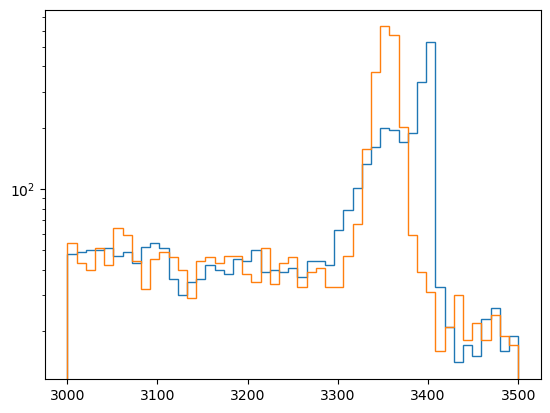

In [57]:
# energy histogram
plt.figure()
plt.yscale('log')
plt.hist(dsp_table['trapEmax'].nda, bins=np.linspace(3000, 3500, 50), histtype='step')
plt.hist(dsp_table['trapEmax_ctc'].nda, bins=np.linspace(3000, 3500, 50), histtype='step')

(array([8., 5., 6., ..., 3., 3., 2.]),
 array([5750.        , 5760.20408163, 5770.40816327, ..., 6229.59183673,
        6239.79591837, 6250.        ]),
 [<matplotlib.patches.Polygon at 0x7fff9b0c06d0>])

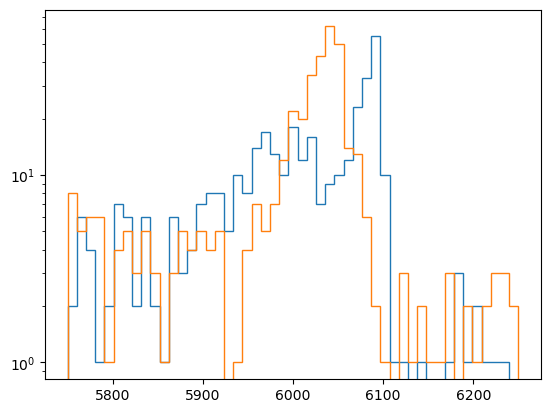

In [58]:
# energy histogram
plt.figure()
plt.yscale('log')
plt.hist(dsp_table['trapEmax'].nda, bins=np.linspace(5750, 6250, 50), histtype='step')
plt.hist(dsp_table['trapEmax_ctc'].nda, bins=np.linspace(5750, 6250, 50), histtype='step')

In [106]:
test_config

{'outputs': ['channel',
  'timestamp',
  'energy',
  'bl',
  'bl_sig',
  'bl_slope_ftp',
  'bl_sig',
  'bl_slope',
  'bl_intercept',
  'wf_max',
  'wf_argmax',
  'fltp',
  'fltp_sig',
  'trapEmax',
  'trapE_argmax',
  'atrap_max',
  'tp_0',
  'trapEftp',
  'trapEmax_ctc',
  'dcr',
  'dtrap_max',
  'qdrift',
  'lt_mean',
  'lt_sig',
  'lt_slope',
  'lt_int',
  'A_10',
  'AoE',
  'triE',
  'ToE',
  'tp_max',
  'tp_02',
  'tp_05',
  'tp_10',
  'tp_20',
  'tp_30',
  'tp_40',
  'tp_50',
  'tp_60',
  'tp_70',
  'tp_80',
  'tp_90',
  'tp_96'],
 'processors': {'bl, bl_sig, bl_slope, bl_intercept': {'function': 'linear_slope_fit',
   'module': 'pygama.dsp.processors',
   'args': ['waveform[0: 3500]', 'bl', 'bl_sig', 'bl_slope', 'bl_intercept'],
   'unit': ['ADC', 'ADC', 'ADC', 'ADC']},
  'wf_blsub': {'function': 'subtract',
   'module': 'numpy',
   'args': ['waveform', 'bl', 'wf_blsub'],
   'prereqs': ['waveform', 'bl'],
   'unit': 'ADC'},
  'wf_bltrap': {'function': 'trap_norm',
   'module': '

In [129]:
# Write this configuration to a file
with open(f'./metadata/dsp/dsp_cyc{cyc}.json', 'w') as f:
    json.dump(test_config, f)